In [1]:
import torchvision as tv
import phototour
import torch
from tqdm import tqdm 
import numpy as np
import torch.nn as nn
import math 
import tfeat_model
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import os


In [2]:
#init tfeat and load the trained weights
tfeat = tfeat_model.TNet()
models_path = '../pretrained-models'
net_name = 'tfeat-yosemite'
tfeat.load_state_dict(torch.load(os.path.join(models_path,net_name+".params")))
tfeat.cuda()
tfeat.eval()

TNet(
  (features): Sequential(
    (0): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
    (5): Tanh()
  )
  (descr): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): Tanh()
  )
)

In [3]:
%%time

import cv2
import tfeat_utils
import numpy as np
import cv2
from matplotlib import pyplot as plt


img1 = cv2.imread('../imgs/v_churchill/1.ppm',0) 
img2 = cv2.imread('../imgs/v_churchill/6.ppm',0)

brisk = cv2.BRISK_create()
kp1, des1 = brisk.detectAndCompute(img1,None)
kp2, des2 = brisk.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(des1,des2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])
print(len(good))       
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,0, flags=2)
plt.imshow(img3),plt.show()

81


<Figure size 640x480 with 1 Axes>

CPU times: user 2.06 s, sys: 104 ms, total: 2.16 s
Wall time: 1.93 s


(<matplotlib.image.AxesImage at 0x7f10158470>, None)

70


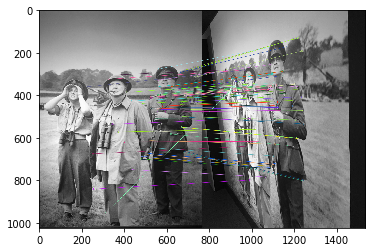

CPU times: user 5.59 s, sys: 1.33 s, total: 6.92 s
Wall time: 6.38 s


(<matplotlib.image.AxesImage at 0x7f101969b0>, None)

In [4]:
%%time

# mag_factor is how many times the original keypoint scale
# is enlarged to generate a patch from a keypoint
mag_factor = 3
desc_tfeat1 = tfeat_utils.describe_opencv(tfeat, img1, kp1, 32,mag_factor)
desc_tfeat2 = tfeat_utils.describe_opencv(tfeat, img2, kp2, 32,mag_factor)

bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(desc_tfeat1,desc_tfeat2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])
print(len(good))        
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,0, flags=2)

plt.imshow(img3),plt.show()